## Learning the infinitesimal generator
Reference papers: 
- _Devergne, Kostic, Pontil, Parrinello, [J. Chem. Phys.](https://doi.org/10.1063/5.0246248) (2025), [ArXiv](https://chemrxiv.org/engage/chemrxiv/article-details/672cd8425a82cea2fa640adc)_

//For a more practical example, see also the more advanced tutorial on training the infinitesimal generator for alanine dipeptide in the examples notebooks.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/adv_infinitesimal_generator.ipynb)


## Introduction
Given a system with position $x$, mass $m$ described by the Langevin equation at inverse temperature $\beta$ and friction $\gamma$:

$$\dfrac{dx}{dt}= -\dfrac{1}{\gamma m} \nabla U(x) + \sqrt{\dfrac{2}{\beta \gamma m}}w(t)$$

We can define the associated infinitesimal generator $\mathcal L$ which will describe the relaxation from an initial probability distribution towards equilibrium:
$$ \dfrac{\partial u_t}{\partial t} = - \mathcal L u_t $$
Where $u_t=p_t/\pi_B$ characterizes the deviation between the instantaneous probability distribution from the equilirbium Boltzmann one.
### Spectral decomposition
We will mostly be interested in the spectral decomposition of $\mathcal L$, ie, we will be looking for the functions $\psi_i$ verifying:
$$\mathcal L \psi_i = \lambda_i \psi_i$$
It can be shown that, $0=\lambda_0 \gt \lambda_1 \gt \lambda_2 \gt \dots $. And the time evolution of the probability density can be written:
$$ u_t(x) = \sum_i \psi_i(x) e^{-\lambda_i t } \langle u_0 | \psi_i\rangle$$
The eigenfunctions and eigenpairs thus characterize typical rare timescales and transitions of the system. Therefore, when interested in transitions from metastable states, we will only look at the lowest part of the spectrum. Below is the example of the eigenfunctions of the generator in a 4 well potential. The zero-th eigenfunction corresponds to the infinite time case, where the system has fully relaxed to the Boltzmann distribution. The other eigenfunctions caracterize the slow modes of the system: the first corresponds to the slowest mode: the transition between the two main basins, while the two others correspond to transitions in the sub-basins.

<center><img src="images/ef_4w.png" width="800" /></center>

### Learning the infinitesimal generator
In order to account numerical stability, we will not directly learn the infinitesimal generator, but its resolvent: $(\eta I +\mathcal L)^{-1}$, where $\eta$ is a positive number. 
Usually, when one wants to learn an operator, given a basis set of function $\phi_i$, one tries to find the matrix $G$ such that $(\eta I +\mathcal L)^{-1} \phi_i \approx \sum_j G_{ij}\phi_j$. This problem admits a closed form, however it relies on the functions $\phi_i$. Therefore, we divide the learning in two parts: first, we learn the functions $\phi_i$ (representation learning), and then, we find the matrix $G$ and its eigenpairs.

#### Representation learning
One choice of a good representation is when  the $\phi_i$ functions are close to the eigenfunctions of $\mathcal L$. It can be shown that $(\psi_i, \lambda_i)$ minimize the following functional:
$$E[\{ \psi_i \};\{\lambda_i\}]=\sum_{i=0}^m\sum_{j=0}^m S_{i,j} \frac  {1}{\eta +\lambda_j} W_{ij}\frac  {1}{\eta +\lambda_i}  -  2 \sum_i^m \frac  {1}{\eta +\lambda_i} S_{i,i} + + \alpha  \text{Tr}(S^\theta-1)^2$$

where the last term is added to ensure orthogonality, and where $S_{ij}= \langle \psi_i \psi_j \rangle$ and $W_{ij}=\eta S_{ij} + \dfrac{\beta}{\gamma m} \langle \nabla \psi_i \nabla \psi_j\rangle$.
Thus, we will optimize this loss using neural networks and $\lambda_i$ as variational parameters.

After the training, one can get the $G$ matrix and the associated eigenvectors/values. The functions are given by:
$\psi_{i} = \sum_j v_{ij} \phi_j$, where $\phi_i$ are the functions of the learned representations and $v_i$ is the i-th eigenvector of $G$.


## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

### Load data

In [2]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights

################################### SET THINGS HERE ###################################
# TODO change data eventually
filenames = ['https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_1/A/COLVAR',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_1/B/COLVAR'
            ]
# TODO change data eventually
load_args = [{'start' : 1000, 'stop': 10000, 'stride': 1},
             {'start' : 1000, 'stop': 10000, 'stride': 1},
            ]                     

# #######################################################################################

dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               create_labels=True,
                                               filter_args={'regex': 'p.x|p.y'}, # to load many positions --> 'regex': 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'
                                               return_dataframe=True,
                                               load_args=load_args,
                                               verbose=True)
# TODO change data eventually
bias = torch.Tensor(dataframe['opes.bias'].values + dataframe['bias'].values)

dataset = compute_committor_weights(dataset, bias, [0,1], beta=1) # it's muller

# create datamodule with only training set
datamodule = DictModule(dataset, lengths=[1])


/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Class 0 dataframe shape:  (9000, 24)
Class 1 dataframe shape:  (9000, 24)

 - Loaded dataframe (18000, 24): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'z.node-0', 'z.bias-0', 'q', 'bias', '@8.bias', '@8.bias_bias', 'opes.bias', 'opes.rct', 'opes.zed', 'opes.neff', 'opes.nker', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (18000, 2): ['p.x', 'p.y']


### Visualize training set

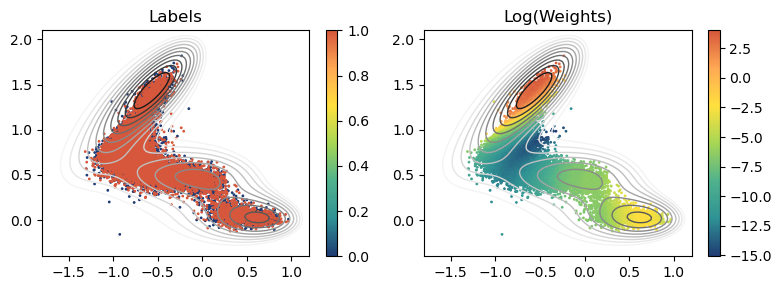

In [3]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot labels
ax = axs[0]
ax.set_title('Labels')

plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=dataset['labels'], s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

# plot weights
ax = axs[1]
ax.set_title('Log(Weights)')
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=torch.log(dataset['weights']), s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

plt.tight_layout()
plt.show()

## Initialize infinitesimal generator model and training variables

### Initialize model
A few tips and tricks about the hyperparameters:
* The theoretical minimum of the loss is: $ -\sum_i{\dfrac{1}{\eta+\lambda_i}}$. Therefore, the smaller $\eta$, the larger the loss, moreover, do not get confused if the loss is negative, this is normal
* $\eta$ and $\alpha$ are two related hyperparameters in competitions: the smaller $\eta$, the larger the first term of the loss, and thus the larger $\alpha$ can be to ensure orthonormality. On the other hand, if $\alpha$ is too big, the learning will proritize orthnormality.
* Beware of overfitting, these models can learn quite fast the optimal solution (from 10000 to 30000 epochs) and then overfit. Usually, this is translated by a decay and then a new plateau in the loss. If you have a validation set, this is seen by the validation loss increasing. 

In [4]:
from mlcolvar.cvs.generator import Generator

# initialize variables
kBT = 1
masses = torch.Tensor([1.0])
n_atoms = 1
gamma = 10

# get friction
friction = kBT / (gamma*masses)
print(friction)

options = { 'nn':{'activation':'tanh'},
            'optimizer' : {'lr': 5e-4, 'weight_decay': 1e-5}}

model = Generator(r=3,
                  layers=[2,20,20,1],
                  eta=0.05,
                  alpha=0.1,
                  friction=friction,
                  n_dim=2,
                  options=options)

tensor([0.1000])


In [6]:
# define callbacks
from mlcolvar.utils.trainer import MetricsCallback

metrics = MetricsCallback()

 # small number of epochs for testing, use 15/20k
trainer = lightning.Trainer(callbacks=[metrics],
                            max_epochs=10000, 
                            num_sanity_val_steps=0,
                            limit_val_batches=0,
                            enable_checkpointing=False,
                            enable_progress_bar = True, #disable progress bar because it made everything bug on my workstation
                            logger=None
                            )
# fit model
trainer.fit(model, datamodule)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | GeneratorLoss | 3      | ?        | ?        
1 | nn      | ModuleList    | 1.5 K  | ?        | ?        
-----------------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-pack

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10000` reached.


### Plot metrics

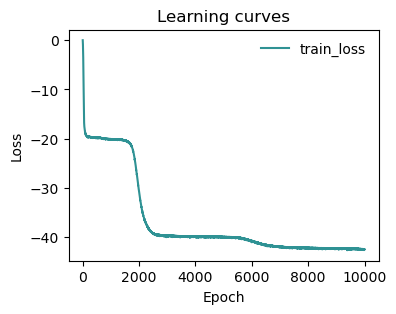

In [7]:
from mlcolvar.utils.plot import plot_metrics, paletteFessa, paletteCortina

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss'],
                  colors=['fessa1', 'fessa3', 'fessa4', 'fessa5'],
                  ax = ax)

## Compute eigenfunctions
Now that you have trained a representation, we can learn the generator on this representation and find the eigenfunctions
* evals are negative, because the original generator has negative eigenvalues so $\lambda_2 \lt \lambda_1 \lt \lambda_0=0$
* evecs correspond to the matrix $v_{ij}$ defined above

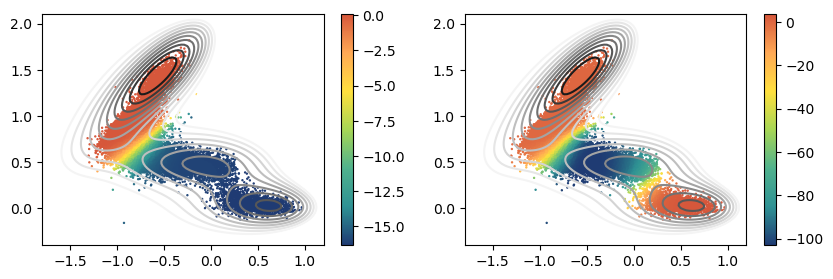

In [8]:
# compute the eigenfunctions for each point in the dataset
    # the parameters of compute_eigenfunctions are already stored in the model.
    # if you want to change them, you can pass them as args (see docstring)
eigenfunctions, evals, evecs = model.cpu().compute_eigenfunctions(dataset, friction=friction,tikhonov_reg=1e-4)

# vsiualize them
fig, axs = plt.subplots(ncols=2,figsize=(10,3))
for i in range(1,3):
    cp = axs[i-1].scatter(dataframe["p.x"], dataframe["p.y"], c=eigenfunctions[:,i].detach(), s=0.5, cmap='fessa')
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0, 24, 12), mode='contour', ax=axs[i-1])
    plt.colorbar(cp, ax=axs[i-1])


In [9]:
evals

tensor([-9.6612e-05, -2.1866e-04, -3.3476e-01])

## Forecast state occupation

### Classify points in the dataset

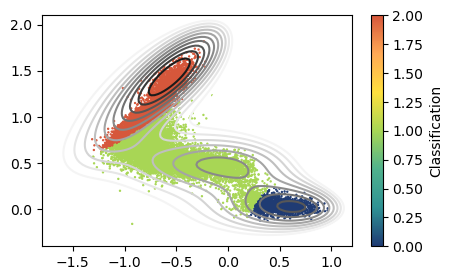

In [10]:
# this helper function helps classifying the states based on the sign of the eigenfunctions, more refined criteria can also be used
def classify_points(array):
    # Initialize classification to 10
    classification = np.ones(array.shape[0], dtype=int) * 10
    
    # Create masks for each condition
    mask_0 = ((array[:, 2] > 0.0) & (array[:, 1] < 0) ) 
    mask_1 = ((array[:, 2] < 0.0) )  
    mask_2 = (array[:, 1] > 0.0)  
    
    # Assign classifications based on conditions
    classification[mask_0] = 0
    classification[mask_1] = 1
    classification[mask_2] = 2

    # Return classification labels (replace numerical classifications)
    return classification

classification = classify_points(eigenfunctions)

fig, axs = plt.subplots(ncols=1,figsize=(5,3))
cp = axs.scatter(dataframe["p.x"], dataframe["p.y"], c=classification, s=0.5, cmap='fessa')
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0, 24, 12), mode='contour', ax=axs)
plt.colorbar(cp, label='Classification')
plt.show()

###  Compute occupation over time
Using the eigenfunctions, we can also compute the occupation of each state with time, given an initial distribution centered in one state, this is done with the following function

In [11]:
from mlcolvar.cvs.generator.utils import forecast_state_occupation

start = 0.01  # A small positive number to avoid log(0)
end = 1000000
num_points = 100  # Adjust the number of points as needed

# the evolution is exponential, so we use a logarithmic scale
times = torch.logspace(np.log10(start), np.log10(end), num_points)

occupations = forecast_state_occupation(eigenfunctions, 
                              evals,
                              times, 
                              torch.Tensor(classification),
                              dataset["weights"], 
                              3)

### Plot occupation over time for the different states

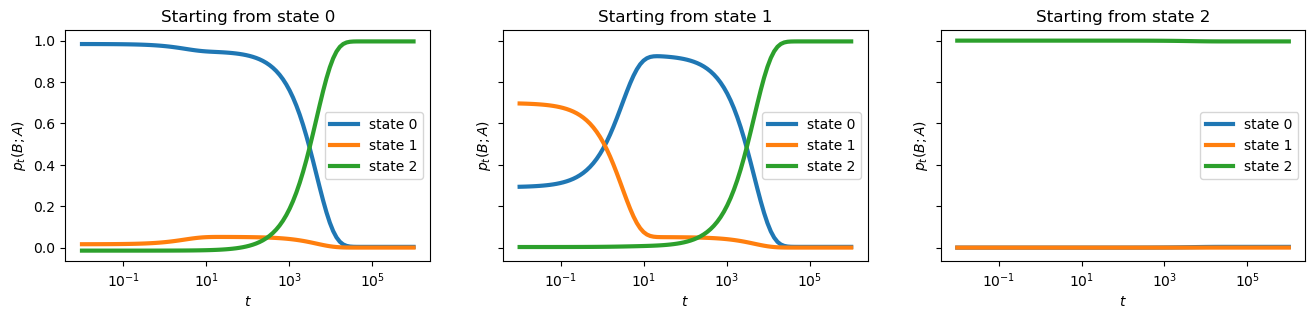

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(16,3), sharey=True)
initial_state = 0
for initial_state in range(0,3):
    for final_state in range(0,3):
        ax = axs[initial_state]
        ax.plot(times.cpu().detach(), occupations[initial_state,final_state].cpu().detach(),linewidth=3,label=f"state {final_state}")
        #ax.plot(times.cpu().detach(), occupations2[initial_state,final_state].cpu().detach(),linewidth=3,label=f"state {final_state}")
        ax.set_xscale("log")
        ax.set_title(f"Starting from state {initial_state}")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$p_t(B;A)$")
    ax.legend()
plt.show()


In [13]:
evals

tensor([ 0.0000e+00, -2.1866e-04, -3.3476e-01])

## Export model with tracing

In [ ]:
traced_model = model.to_torchscript(file_path='test_trace.pt', method='trace')

: 